In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Overview

This project explores how to use WENO reconstruction (first described in [this paper](https://www.sciencedirect.com/science/article/pii/S0021999184711879)) to solve the 1D Euler gas equations.

The Euler gas equations can be written as a system of hyperbolic 1D equations, as described in several places, e.g.[here](http://www.clawpack.org/riemann_book/html/Euler.html#:~:text=Hyperbolic%20structure%20of%20the%201D%20Euler%20equations&text=q%3D(%CF%81%CF%81uE,the%20one%2Ddimensional%20Euler%20system.).

In this form they are like a coupled system of three conservation laws in density (which we'll call "r"), pressure (p), and velocity (u).

One way to use WENO to solve the euler equations is as described [here](http://math.tifrbng.res.in/~praveen/pub/ncm2019.pdf), by projecting into the characteristics, then WENO reconstructing, and then using these estimates with Local-Lax-Friedrichs fluxes to get the values we're interested in.

We test on simple linear advection, i.e. when the density as a function of x is a sinusoid (1 + 0.5 sin(2pix)), and the initial pressure and energy are some constant everywhere. Under these conditions the pressure and velocity should never change and the density is advected, returning periodically to the initial distribution. The code here tests the dependence of the error on spacing to confirm that WENO reconstruction gives us 3rd order accuracy.

The more intriguing case we test is the Sod problem, described [here](https://www.astro.uu.se/~hoefner/astro/teach/ch10.pdf). The problem is to simulate what happens in a closed tube when two regions of different pressure that were once separated are suddenly freely allowed to interact. We get a shock wave and the expected solutions are described in the previous link. We graph the solutions obtained by our solver to check for correctness.

## Physics helper functions and WENO reconstruction

We next implement necessary functions to define the relationships between the physical quantities in question and set up the WENO reconstruction, Local-Lax-Friedrichs flux function, and a 3rd order runge-kutta solver for the problem.

In [2]:
#Define F on the *primitive* variables
#R/Rinv is the similarity transform to get to the characteristics
#helper functions:

#the function F for which the equations look like v_t + (F(v))_x = 0 (underscores = partial derivatives)
#Here v = a tuple of (r, ru, e) with r = density, u = velocity, e = energy
#Each of r,u,e are differentiable functions from the space (x,t) -> R (real numbers)
def F(v):
    #u is a vector of 3-tuples, (density, density*velocity, energy)
    r = v[0] #density
    ru = v[1] #density*velocity
    e = v[2] #energy
    gam = 1.4 #adiabatic constant for a diatomic gas, like typical air
    p = (gam - 1)*(e - 0.5*r*(ru/r)**2) #caloric equation of state (How pressure is related to e,r,u)
    
    #returning the 3-tuple that makes the equations look like conservation laws
    f_cons = np.zeros(3,dtype=np.float64)
    f_cons[0] = ru
    f_cons[1] = p + r*(ru/r)**2
    f_cons[2] = (e + p)*(ru/r)
    return f_cons

# Motivation - we're generalizing the method of characteristics like so:
# each of r, u, e are functions from (x,t) ->  R (real numbers)
# imagine r,u,e to be coordinate functions of v(x,t) :R^2 -> R^3
# a characteristic is a curve (x(t),t) s.t. along the curve v(x(t),t) = v(x(0),0) = constant
# We started with this equation:
# (F_v)(v(x(t),t))_x + v(x(t),t)_t = 0 (Here F_v is the Jacobian of F:R^3->R^3 above)
# F_v is a constant matrix along a given characteristic (throughout, we're going to stay on a characteristic)
# Suppose then that F_v is diagonalized as R D R^-1, (D diagonal, R,D constant)
# It's now perfectly legitimate to do
# D (R^-1 v(x(t),t)_x + (R^-1 v(x(t),t))_t = 0
# In the transformed coordinates R^-1(v), we have three nicely separated 1D equations (bc D is diagonal)
# Once we solve this nicer system, we just project back by multiplying by R for the solution we need!

# This function returns exactly the matrix R that projects *out* of characteristic space
def R(v):
    #extracting density, density*velocity, energy as before
    r = v[0]
    ru = v[1]
    e = v[2]
    gam = 1.4
    p = (gam - 1)*(e - 0.5*r*(ru/r)**2) #caloric equation of state (finding pressure)
    a = (gam*p/r)**0.5 #speed of sound in the medium
    u = ru/r #velocity
    H = (e + p)/r #enthalpy
    
    #returning the change of basis matrix
    char_proj_mat = np.zeros((3,3),dtype=np.float64)
    char_proj_mat[0] = np.array([1.0,1.0,1.0])
    char_proj_mat[1] = np.array([u-a,u,u+a])
    char_proj_mat[2] = np.array([H - u*a, 0.5*u**2, H + u*a])
    return char_proj_mat

#Returning R^-1, which projects *into* characteristic space
def Rinv(v):
    return la.inv(R(v))

In [3]:
#a helper function that extracts the quantities r (density), u (velocity), p (pressure), E (energy)
#when given a vector
def get_rupe(v):
    gam = 1.4 #adiabatic constant for diatomic gas
    r = v[0,:] #density
    ru = v[1,:] #density*velocity
    E = v[2,:] #energy
    u = np.multiply(ru,r**-1.0) #velocity
    p = (gam - 1)*(E - 0.5*np.multiply(r,u**2)) #caloric equation of state - pressure
    return r,u,p,E

In [4]:
#the WENO reconstruction function, which takes cell averages and returns the "winded" averages
#the reason for the numbers being what they are is carefully explained in the original paper and the reference
#basically, interpolating this way gives us reconstructions that are 3rd-order accurate, based on taylor considerations
def weno3(v0,v1,v2,d):
    #v0, v1, v2 are the three estimates from three different stencils around the point in question
    #d is the derivative which helps us decide which way to weight
    p0 = 1.5*v1 - 0.5*v0 #"polynomials" - but evaluated at the point
    p1 = 0.5*(v1 + v2)
    b0 = (v1 - v0)**2 #smoothing factors
    b1 = (v2 - v1)**2
    eps = 1e-7
    retval = np.zeros(3,dtype=np.float64)
    for i in range(3): #combining in the required ratios for third order accuracy
        if d[i] >= 0: 
            a0 = 0.5/((eps + b0[i])**2)
            a1 = 1.0/((eps + b1[i])**2)
        else:
            a0 = 1.0/((eps + b0[i])**2)
            a1 = 0.5/((eps + b1[i])**2)
        retval[i] = (a0*p0[i] + a1*p1[i])/(a0 + a1)
    return retval

#a helper function that calculates velocity and the speed of sound in a given medium
def get_ua(v):
    r = v[0]
    ru = v[1]
    e = v[2]
    gam = 1.4
    p = (gam - 1)*(e - 0.5*r*(ru/r)**2) #caloric equation of state
    a = (gam*p/r)**0.5 #speed of sound in the medium
    u = ru/r #velocity
    return u, a

#will be done using the characteristics
#this is the all important reconstruction function, that computes the characteristics and stencils
#and then passes them to the WENO3 function to get 3rd order estimates. Then it undoes the characteristic
#transformation and passes the left and right cell estimates to the Lax-Friedrichs function, along with
#information about the derivative everywhere (which is necessary)
def reconstruct(v,b):
    n = v.shape[1]
    vl = np.zeros((3,n+1),dtype=np.float64) #the left endpoints for lax friedrichs
    vr = np.zeros((3,n+1),dtype=np.float64) #the right endpoint for lax friedrichs
    lams = np.zeros(n+1,dtype=np.float64) #where we will store information about the derivatives
    for i in range(n+1): #at cell i, we need four points around it to get three stencils of three points each
        indl = i - 2 #index of point to the left
        ind = i - 1 #index of the point
        indr = i #index of the point to the right
        indr2 = i+1 #index of point two steps to the right
        
        #handling periodic boundary conditions - basically moving modulo n when we fall off any end
        if indl < 0:
            if b == "p":
                indl = indl + n
            else:
                continue
        if ind < 0:
            if b == "p":
                ind = ind + n
            else:
                continue
        if indr >= n:
            if b == "p":
                indr = indr - n
            else:
                continue
        if indr2 >= n:
            if b == "p":
                indr2 = indr2 - n
            else:
                continue

        #with characteristics
        v_h = 0.5*(v[:,ind] + v[:,indr]) #getting an average around the point
        r_h = R(v_h) #the characteristic matrix, defining a local linear transformation from chars to u
        l_h = Rinv(v_h) #the inverse matrix, which goes from u to chars
        
        #the characteristic speeds at the point are u-a, u, u + a, u = velocity, a = speed of sound at the point
        #the maximum of these speeds is information we need for the lax-friedrichs function later
        left_u, left_a = get_ua(v[:,ind])
        right_u, right_a = get_ua(v[:,indr])
        dl = np.array([left_u - left_a, left_u, left_u + left_a])
        dr = np.array([right_u - right_a, right_u, right_u + right_a])
        
        #now weno reconstructing on the characteristics using the inverse transformation that takes us into char space
        w0 = np.dot(l_h,v[:,indl])
        w1 = np.dot(l_h,v[:,ind])
        w2 = np.dot(l_h,v[:,indr])
        w3 = np.dot(l_h,v[:,indr2])
        ret1 = weno3(w0,w1,w2,dl) #3rd order WENO function for the left estimate
        ret2 = weno3(w3,w2,w1,dr) #3rd order WENO for the right estimate
        
        #undoing the coordinate transformation back into local coordinates
        vl[:,i] = np.dot(r_h,ret1)
        vr[:,i] = np.dot(r_h,ret2)
        lams[i] = np.max(np.array([np.max(np.abs(dl)),np.max(np.abs(dr))])) #remembering max char speed for LLF

    #apart from periodic conditions, we have Neumann conditions
    #this is a taylor based construction accurate to third order
    if b == "n":
        vl[:,0] = (4*vl[:,2] - vl[:,4])/3
        vl[:,1] = (3*vl[:,0] + vl[:,2])/4
        
        vr[:,0] = (4*vr[:,2] - vr[:,4])/3
        vr[:,1] = (3*vr[:,0] + vr[:,2])/4
        
        vl[:,n] = (4*vl[:,n-3] - vl[:,n-6])/3
        vl[:,n-2] = (3*vl[:,n] + vl[:,n-4])/4
        vl[:,n-1] = (3*vl[:,n] + vl[:,n-2])/4
        
        vr[:,n] = (4*vr[:,n-3] - vr[:,n-6])/3
        vr[:,n-2] = (4*vr[:,n] - vr[:,n-4])/3
        vr[:,n-1] = (3*vr[:,n] + vr[:,n-2])/4
        
        lams[0] = np.max(lams)
        lams[1] = lams[0]
        lams[n] = lams[0]
        lams[n-1] = lams[0]
        
    return vl, vr, lams

In [5]:
#the local lax-friedrichs function, which computes flux values at interfaces
#this is standard, vl = v-, vr = v+ as in most descriptions
def LLFs(v,b):
    vl, vr, lams = reconstruct(v,b)
    f_vr = np.apply_along_axis(F,0,vr)
    f_vl = np.apply_along_axis(F,0,vl)
    diffs = 0.5*np.multiply(lams,vr - vl)
    retval = 0.5*(f_vr + f_vl) - diffs
    return retval, np.max(lams) #the maximum derivative is needed for Local Lax Friedrich's combination parameter

In [6]:
#L = difference of the lax friedrichs function at adjacent points
#typically the hyperbolic conservation law equation is just v_new = v + param*(L), here lam = param
def L(v,b):
    ns = v.shape[1]
    dx = 1.0/ns
    f, lam = LLFs(v,b)
    retval = -1.0*(f[:,1:] - f[:,0:-1])/dx
    return retval, lam

In [7]:
#finally using the L function above with a 3rd order accurate Runge-Kutta method
#uses the v = v_old + lam*L finite volume equation
def solve(ics, b, T):
    t = 0
    v = np.copy(ics)
    n = v.shape[1]
    dx = 1.0/n
    while t < T:
        L0, lam = L(v,b)
        dt = min(1.0/(n*lam),1.0/n)
        v1 = v + dt*L0
        L1, lam = L(v1,b)
        v2 = 0.75*v + 0.25*(v1 + dt*L1)
        L2, lam = L(v2,b)
        v = (v/3.0) + 2*(v2 + dt*L2)/3.0
        t = t + dt
    return v

## Defining initial conditions

We make initial conditions for both the sod problem and the advection problem.

For advection density varies as 1 + 0.5 sin(2pi\*x) over the tube, and velocity, energy are some constant.
Our vector is (density, density\*velocity, energy) in the primitive variables

For the sod problem density "r" is two constant regions with an abrupt drop between them, u = 0, and energy abruptly shifts between the two regions (related to pressure by a factor of 1/(gam-1)).

In [8]:
def make_per_ics(n):
    gam = 1.4
    retval = np.zeros((3,n),dtype=np.float64)
    retval[0] = 1.0 + 0.5*np.sin(2*np.pi*np.linspace(0,1,n, endpoint=False))
    retval[1] = 1.0 + 0.5*np.sin(2*np.pi*np.linspace(0,1,n, endpoint=False))
    retval[2] = 1.0/(gam - 1) + 0.5*retval[0]
    return retval

In [9]:
def make_sod_ics(n):
    gam = 1.4
    retval = np.zeros((3,n),dtype=np.float64)
    ps = np.linspace(0,1,n) #changed from 0 to 1
    retval[0] = np.array([0.125 if v > 0.5 else 1.0 for v in ps])
    retval[2] = np.array([0.1 if v > 0.5 else 1.0 for v in ps])*1.0/(gam - 1)
    return retval

## Solving the Sod problem

Now we finally solve the Sod problem with our solver. Expected solutions are shown [here](http://ammar-hakim.org/sj/je/je2/je2-euler-shock.html). We don't check the order of accuracy here because the shocks are hard to deal with, but will in the next code snippet. The sod solution takes about 10s to run.

Running solver... (takes about 10 s)
Done!


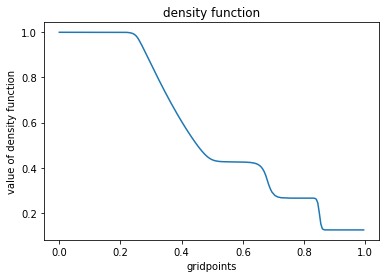

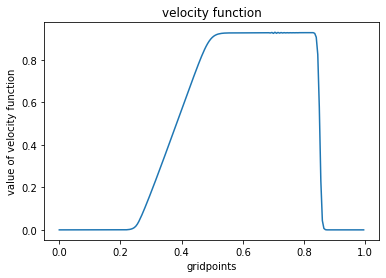

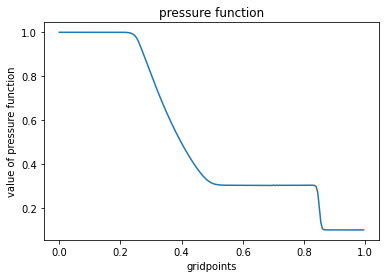

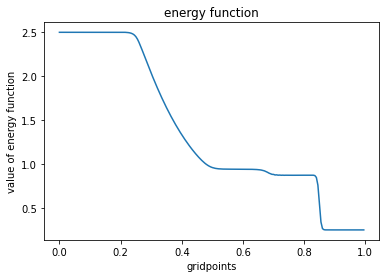

In [10]:
n = 200


def plot(vs, data, xlabel, ylabel, title):
    plt.figure()
    plt.plot(vs,data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

sod_ics = make_sod_ics(n)
print("Running solver... (takes about 10 s)")
sol = solve(sod_ics,"n",0.2)
print("Done!")
r, u, p, E = get_rupe(sol)

vs = np.linspace(0,1,n,endpoint=False)

plot(vs,r,"gridpoints","value of density function","density function")

plot(vs,u,"gridpoints","value of velocity function","velocity function")

plot(vs,p,"gridpoints","value of pressure function","pressure function")

plot(vs,E,"gridpoints","value of energy function","energy function")

## Verifying accuracy on Advection

Finally we test that our solution on advection is third order accurate.
We'll divide the interval into 100, 200, and 400 points and then create a log plot of the errors obtained.
Accuracy is measured by the slope of the plot line and not by its absolute location in the graph. Running this next snippet should produce the expected slope and it should be visibly parallel to third order error, steeper than both order 1 and 2 even if it overlaps absolutely with any of them.
The time it takes depends roughly quadratically on grid spacing. On average the 100 points take 5 seconds, 200 points take 20 seconds, and 400 points take 80 seconds, for a total of about 2 minutes.

Solving when grid spacing is 100
Solving when grid spacing is 200
Solving when grid spacing is 400


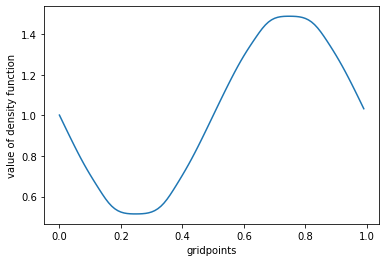

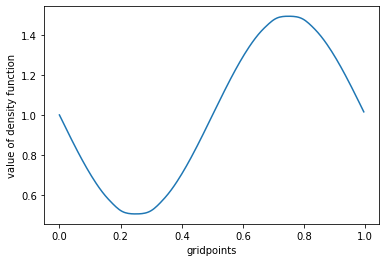

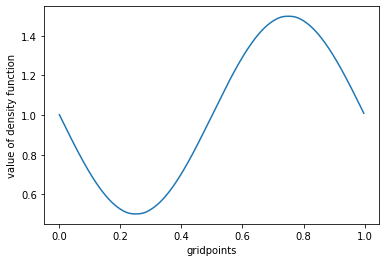

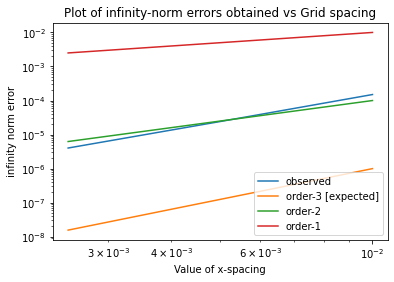

In [11]:
n = 100
hs = []
errs_inf = []
for i in range(3):
    p_ics = make_per_ics(n)
    print("Solving when grid spacing is " + str(n))
    sol = solve(p_ics,"p",0.5) #initial and exact should be the same in this case
    r, u, p, E = get_rupe(sol)
    r_e, u_e, p_e, E_e = get_rupe(p_ics)
    errs_inf.append(la.norm(r - (2.0-r_e),np.inf)*1.0/n) #after half a period, density is just 2 - initial
    vs = np.linspace(0,1,n,endpoint=False)
    plt.plot(vs,r)
    plt.xlabel("gridpoints")
    plt.ylabel("value of density function")
    plt.figure()
    #errs_1.append(la.norm(r - r_e,1)*1.0/n)
    hs.append(1.0/n)
    n = n*2


plt.loglog(hs,errs_inf, label="observed")
plt.loglog(hs,np.array(hs)**3,label="order-3 [expected]")
plt.loglog(hs,np.array(hs)**2,label="order-2")
plt.loglog(hs,np.array(hs),label="order-1")
plt.legend()
plt.xlabel("Value of x-spacing")
plt.ylabel("infinity norm error")
plt.title("Plot of infinity-norm errors obtained vs Grid spacing")
plt.show()